### Using an amino acid replacement matrix as a prior

When aggregating sequences of different evolutionary distances to a consensus, the residual level features should depend on the estimated distance of their sequence to the current consensus (i.e. it should be allowed that distant sequences can contribute differently than close ones).

To that end, we replace a strict one-hot encoding of amino acids by expected aminoacid distributions after different evolutionary times $\tau_i$ (where $\tau_i$ = 1 expected mutation per site). For example, isoleucine and valine have a high exchange rate and therefore, if $\tau$ is large, the one-hot encoding of an observed isoleucine will be smoothed towards valine and vice versa.

A model can weight the features per $\tau_i$ based on an estimated distance of each sequence to the consensus before aggregating over the sequence dimension.

Inputs:
- A rate matrix $Q$ of a continuous-time Markov chain with $Q_{ii}$ such that the rows sum up to 0.
- Considered evolutionary times $\tau$.

For $Q$, we assume LG (An Improved General Amino Acid Replacement Matrix, Le, Si Quang and Gascuel, Olivier, 2008)

The file LG.PAML.txt contains the lower triangle of the symmetric exchangeability matrix (i.e. $s_{ij} = s_{ji}$ is the exchangeability from aminoacid $i$ to $j$).
It also contains relative frequencies of all aminoacids $\pi_i$. The net replacement rate is then $q_{ij}=s_{ij} * \pi_j$. We normalize $Q$ such that 1 time unit = 1 expected mutation per site. This can be done by scaling $Q$ by $\frac{1}{\mu}$ with $\mu = - \sum_{i=1}^{20} \pi_i Q_{ii}$ (although $Q$ should already be normalized most of the times).

In [1]:
import numpy as np
import tensorflow as tf
import Data as data

def read_paml_file(file):
    with open(file, "r") as paml:
        Q = np.zeros((20, 20), dtype=np.float32)
        content = paml.readlines()
        s = [np.fromstring(content[i], sep=" ") for i in range(19)]
        pi = np.fromstring(content[20], sep=" ")
        for i in range(20):
            for j in range(i):
                Q[i,j] = s[i-1][j] * pi[j]
                Q[j,i] = s[i-1][j] * pi[i]
        r = np.arange(20)
        Q -= np.sum(Q, axis=-1) * np.eye(20)
        mue = - np.sum(pi * np.diagonal(Q))
        Q /= mue
        return Q 
            
            
Q = read_paml_file("LG.PAML.txt")
tau = np.array([0.01, 0.5, 2.5], dtype=np.float32) # considered evolutionary times

In [2]:
tauQ = np.reshape(tau, [-1,1,1]) * np.reshape(Q, [1,20,20])

P = tf.linalg.expm(tauQ) # P[r,i,j] = P(X(tau_r) = j | X(0) = i)

# X.shape = (num_seq, len_seq, len_alphabet)
def make_anc_probs(X):
    print(P.shape)
    print(X.shape)
    ancprobs = tf.einsum("sti,rij -> srtj", X, P) # Einstein sum, compute all ancestral character probs simultaneously
    return ancprobs.numpy()

aa = np.expand_dims(np.eye(20, dtype=np.float32),0)
aa_ancprobs = make_anc_probs(aa)
aa_ancprobs.shape

(3, 20, 20)
(1, 20, 20)


(1, 3, 20, 20)

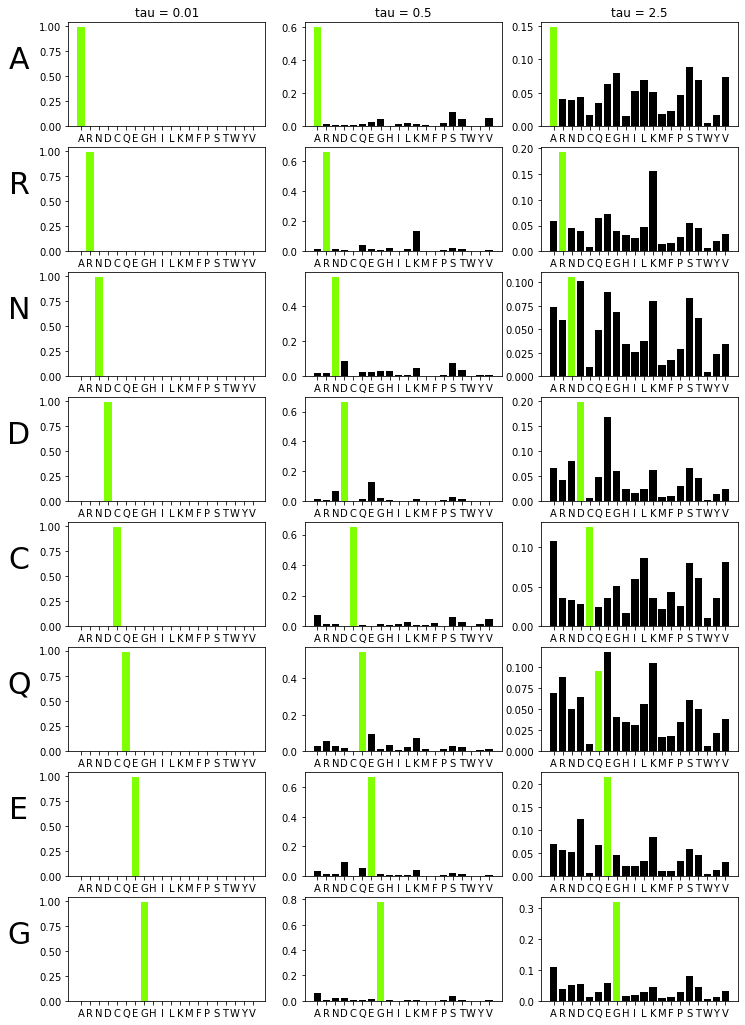

In [3]:
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (12, 18)

# run this cell to visualize aminoacids at different evolutionary distances
n_rows = 8
n_cols = aa_ancprobs.shape[1]
fig, axes = plt.subplots(n_rows, n_cols)
for i,ax in enumerate(axes):
    for j,a in enumerate(ax):
        #a.set_ylim((0,1))
        a.bar(data.ALPHABET[:20], aa_ancprobs[0,j, i],
                color =['chartreuse' if x == i else "black" for x in range(20)])
        if i == 0:
            a.set_title("tau = "+str(tau[j]))
        if j == 0:
            a.set_ylabel(data.ALPHABET[i], rotation=0, size=30, labelpad=20)
#fig.suptitle("Aminoacid distributions corrected for different evolutionary distances based on the LG rate matrix.")

#plt.show()
plt.savefig("results/rate_matrix_prior.pdf", bbox_inches='tight')